In [58]:
import tensorflow as tf
from tensorflow.keras import layers, models
import keras_tuner as kt
import matplotlib.pyplot as plt

import tempfile

In [59]:
# loading dataset

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

In [60]:
# data preprocessing / data augmentation

def preprocess(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.expand_dims(image, -1)
    return image, label

def augmentation(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.1)
    return image, label

batch_size = 32

# train dataset
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_ds = train_ds.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.map(augmentation, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.shuffle(buffer_size=1024).batch(batch_size).prefetch(tf.data.AUTOTUNE)

# test dataset
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_ds = test_ds.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
test_ds = test_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [61]:
# CNN architeture with keras tuner

def model_builder(hp):
    # sequential model & input layer
    model = models.Sequential()
    model.add(layers.Input(shape=(28,28,1)))

    #first hidden cnn layer with ajustable hyperparameters
    hp_filters1 = hp.Int('filters_1', min_value=16, max_value=64, step=16)
    hp_kernel_size1 = hp.Choice('kernel_size_1', values=[3,5])
    model.add(layers.Conv2D(filters=hp_filters1,
                            kernel_size=(hp_kernel_size1, hp_kernel_size1),
                            activation='relu'
                            ))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    # second hidden cnn layer with ajustable hyperparameters
    hp_filters2 = hp.Int('filters_2', min_value=32, max_value=128, step=32)
    hp_kernel_size2 = hp.Choice('kernel_size_2', values=[3,5])
    model.add(layers.Conv2D(filters=hp_filters2,
                            kernel_size=(hp_kernel_size2, hp_kernel_size2),
                            activation='relu'
                            ))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    # flatten layer for dense layer
    model.add(layers.Flatten())

    # hidden dense layer with ajustable units
    hp_units = hp.Int('units_dense', min_value=64, max_value=256, step=64)
    model.add(layers.Dense(units=hp_units, activation='relu'))

    # output dense layer
    model.add(layers.Dense(10, activation='softmax'))

    # model compile with ajustable learning rate
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [62]:
# callbacks 
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, verbose=1),
    #tf.keras.callbacks.ModelCheckpoint('best_nn_model.keras', monitor='val_loss', save_best_only=True, verbose=1),
]


In [63]:
tuner = kt.BayesianOptimization(
    hypermodel=model_builder,
    objective='val_accuracy',
    max_trials=3,
    directory=tempfile.mkdtemp(),
    project_name='mmnist_cnn_tuning'
)

tuner.search(x_train, y_train, epochs=5, validation_split=0.2, callbacks=callbacks)

Trial 3 Complete [00h 00m 20s]
val_accuracy: 0.9252499938011169

Best val_accuracy So Far: 0.9825833439826965
Total elapsed time: 00h 01m 44s


In [64]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

best_model = tuner.hypermodel.build(best_hps)

history = best_model.fit(x_train, y_train, epochs=10, validation_split=0.2, callbacks=callbacks)

Epoch 1/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.8336 - loss: 1.5017 - val_accuracy: 0.9632 - val_loss: 0.1464
Epoch 2/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.9691 - loss: 0.1179 - val_accuracy: 0.9764 - val_loss: 0.0967
Epoch 3/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.9824 - loss: 0.0602 - val_accuracy: 0.9697 - val_loss: 0.1121
Epoch 4/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.9894 - loss: 0.0362 - val_accuracy: 0.9767 - val_loss: 0.0858
Epoch 5/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.9918 - loss: 0.0264 - val_accuracy: 0.9838 - val_loss: 0.0661
Epoch 6/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.9935 - loss: 0.0200 - val_accuracy: 0.9842 - val_loss: 0.0643
Epoch 7/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.9958 - loss: 0.0129 - val_accuracy: 0.9852 - val_loss: 0.0673
Epoch 8/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.9959 - loss: 0.0132

In [67]:
test_loss, test_acc = best_model.evaluate(x_test, y_test)
print(f"acc on the test set: {test_acc:.4f}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9859 - loss: 0.0605
acc on the test set: 0.9886


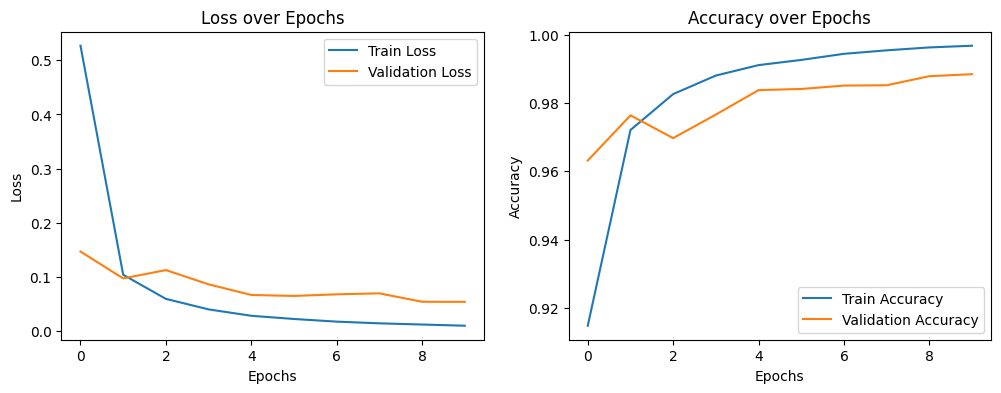

In [68]:
def plot_training_history(history):
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))

    # loss
    axs[0].plot(history.history['loss'], label='Train Loss')
    axs[0].plot(history.history['val_loss'], label='Validation Loss')
    axs[0].set_title('Loss over Epochs')
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Loss')
    axs[0].legend()

    # acc
    axs[1].plot(history.history['accuracy'], label='Train Accuracy')
    axs[1].plot(history.history['val_accuracy'], label='Validation Accuracy')
    axs[1].set_title('Accuracy over Epochs')
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('Accuracy')
    axs[1].legend()

    plt.show()

plot_training_history(history)